In [1]:
%%capture
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
import xarray as xr
import os
import gsw
import time
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d, PchipInterpolator

In [2]:
cluster = SLURMCluster(queue='any2', cores=24, memory='24GB', processes=6)
cluster

In [3]:
client = Client(cluster)
client

Client Scheduler: tcp://192.168.0.13:39531 Dashboard: http://192.168.0.13:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [4]:
def get_data(argo_file):
    argo_file = xr.open_dataset(argo_file)
    lats = argo_file.LATITUDE.data
    lons = argo_file.LONGITUDE.data
    lons = np.where(lons<0, lons+360,lons)
    date = argo_file.JULD.data[0]
    date = np.repeat(pd.to_datetime(date).date(), len(lons))
    temp = argo_file.TEMP[:,0].data
    nprof = argo_file.N_PROF.data
#     new_temp =[]
#     for row in temp:
#         new_temp.append(row)
    df = {'date':date,'lat':lats,'lon':lons,'nprof':nprof,'temp':temp}
    pairs = pd.DataFrame(df,columns=['date','lat','lon','nprof','temp'])
    return pairs

In [5]:
ARGO_DIR = '/data/datos/ARGO/data/'
argo_files = [os.path.join(ARGO_DIR,x) for x in os.listdir(ARGO_DIR) if x.endswith('_prof.nc')]
len(argo_files)

7189

In [42]:
data = pd.DataFrame([],columns=['date','lat','lon','nprof','temp'])
for file in argo_files:
    data = data.append(get_data(file))

In [43]:
data.head()

,date,lat,lon,nprof,temp
0,1999-04-11,38.856,145.190,0,12.020
1,1999-04-11,40.624,154.200,1,8.212
0,1999-01-01,42.621,155.969,0,8.692
0,1999-04-10,38.087,149.431,0,12.452
1,1999-04-10,39.776,143.998,1,11.268


In [44]:
data.to_csv('latlontemp.txt', index=False)

In [6]:
data = pd.read_csv('latlontemp.txt')
data.head()

,date,lat,lon,nprof,temp
0,1999-04-11,38.856,145.190,0,12.020
1,1999-04-11,40.624,154.200,1,8.212
2,1999-01-01,42.621,155.969,0,8.692
3,1999-04-10,38.087,149.431,0,12.452
4,1999-04-10,39.776,143.998,1,11.268


In [7]:
data['date'] = pd.to_datetime(data['date'])

In [8]:
def filter_data(data, min_lat, min_lon, max_lat, max_lon,time1, time2):
    max_lat = max_lat
    max_lon = max_lon+1
    filt = data[(data['date']>time1)&(data['date']<time2)]
    filt = filt[(filt['lat']>min_lat)&(filt['lat']<max_lat)]
    filt = filt[(filt['lon']>min_lon)&(filt['lon']<max_lon)]
    x_grid = np.arange(min_lon,max_lon,0.5)
    y_grid = np.arange(min_lat,max_lat,0.5)
    return filt, x_grid, y_grid

In [9]:
date1 = "1999-01-01"
date2 = '2019-12-31'
filt_data, x_grid, y_grid = filter_data(data,-20,250,10.5,300,np.datetime64(date1),np.datetime64(date2))
filt_data.head()

,date,lat,lon,nprof,temp
1314,2000-07-13,-13.006,252.005997,1,23.901
1342,2000-07-23,-13.048,251.841003,0,23.711
1380,2000-08-03,-13.387,251.442001,1,23.445
1421,2000-08-13,-13.714,250.760002,0,23.454
1458,2000-08-24,-13.921,250.117996,7,23.634


In [10]:
# x_grid = np.arange(260,280,1)
# y_grid = np.arange(-20,10,1)
H, xedges, yedges =np.histogram2d(filt_data['lon'], filt_data['lat'], bins=(x_grid, y_grid))
H = H.T
H.shape

(60, 101)

In [11]:
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
plt.style.use('seaborn-paper')

proj = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(subplot_kw=dict(projection=proj),figsize=(24,12))
ax.set_xticks(np.arange(0,360,5), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90,90,2.5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
X, Y = np.meshgrid(xedges, yedges)

hq_land = cfeature.NaturalEarthFeature(
                            category='physical',
                            name='land',
                            scale='50m',
                            facecolor=cfeature.COLORS['land'])
hq_border = cfeature.NaturalEarthFeature(
                            category='cultural',
                            name='admin_0_countries',
                            scale='50m',
                            facecolor=cfeature.COLORS['land'],
                            edgecolor='black')
#ax.add_feature(hq_land)
ax.add_feature(hq_border)
ax.set_extent([70, 110, -20, 10], crs=proj)

draw = ax.pcolormesh(X, Y, H,edgecolor='w',lw=0.004,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('GnBu',10))
cbar = plt.colorbar(draw, ticks = np.arange(np.min(H),np.max(H),10))
cbar.ax.tick_params(labelsize=15) 
# for i in range(len(yedges)-1):
#     for j in range(len(xedges)-1):
#         text = ax.text(j, i, H[i, j],
#                        ha="center", va="center", color="w")
# ax.plot(lats[~np.isnan(lats)]-180,lons[~np.isnan(lons)],ls='-',lw=1)
ax.coastlines()
fig.savefig('hist_argo.png', dpi=400)

In [12]:
from scipy.stats.kde import gaussian_kde
x = filt_data['lon'].values
y = filt_data['lat'].values
k = gaussian_kde(np.vstack([x, y]))

In [13]:
xi, yi = np.mgrid[x.min():x.max():H.shape[1]*1j,y.min():y.max():H.shape[0]*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

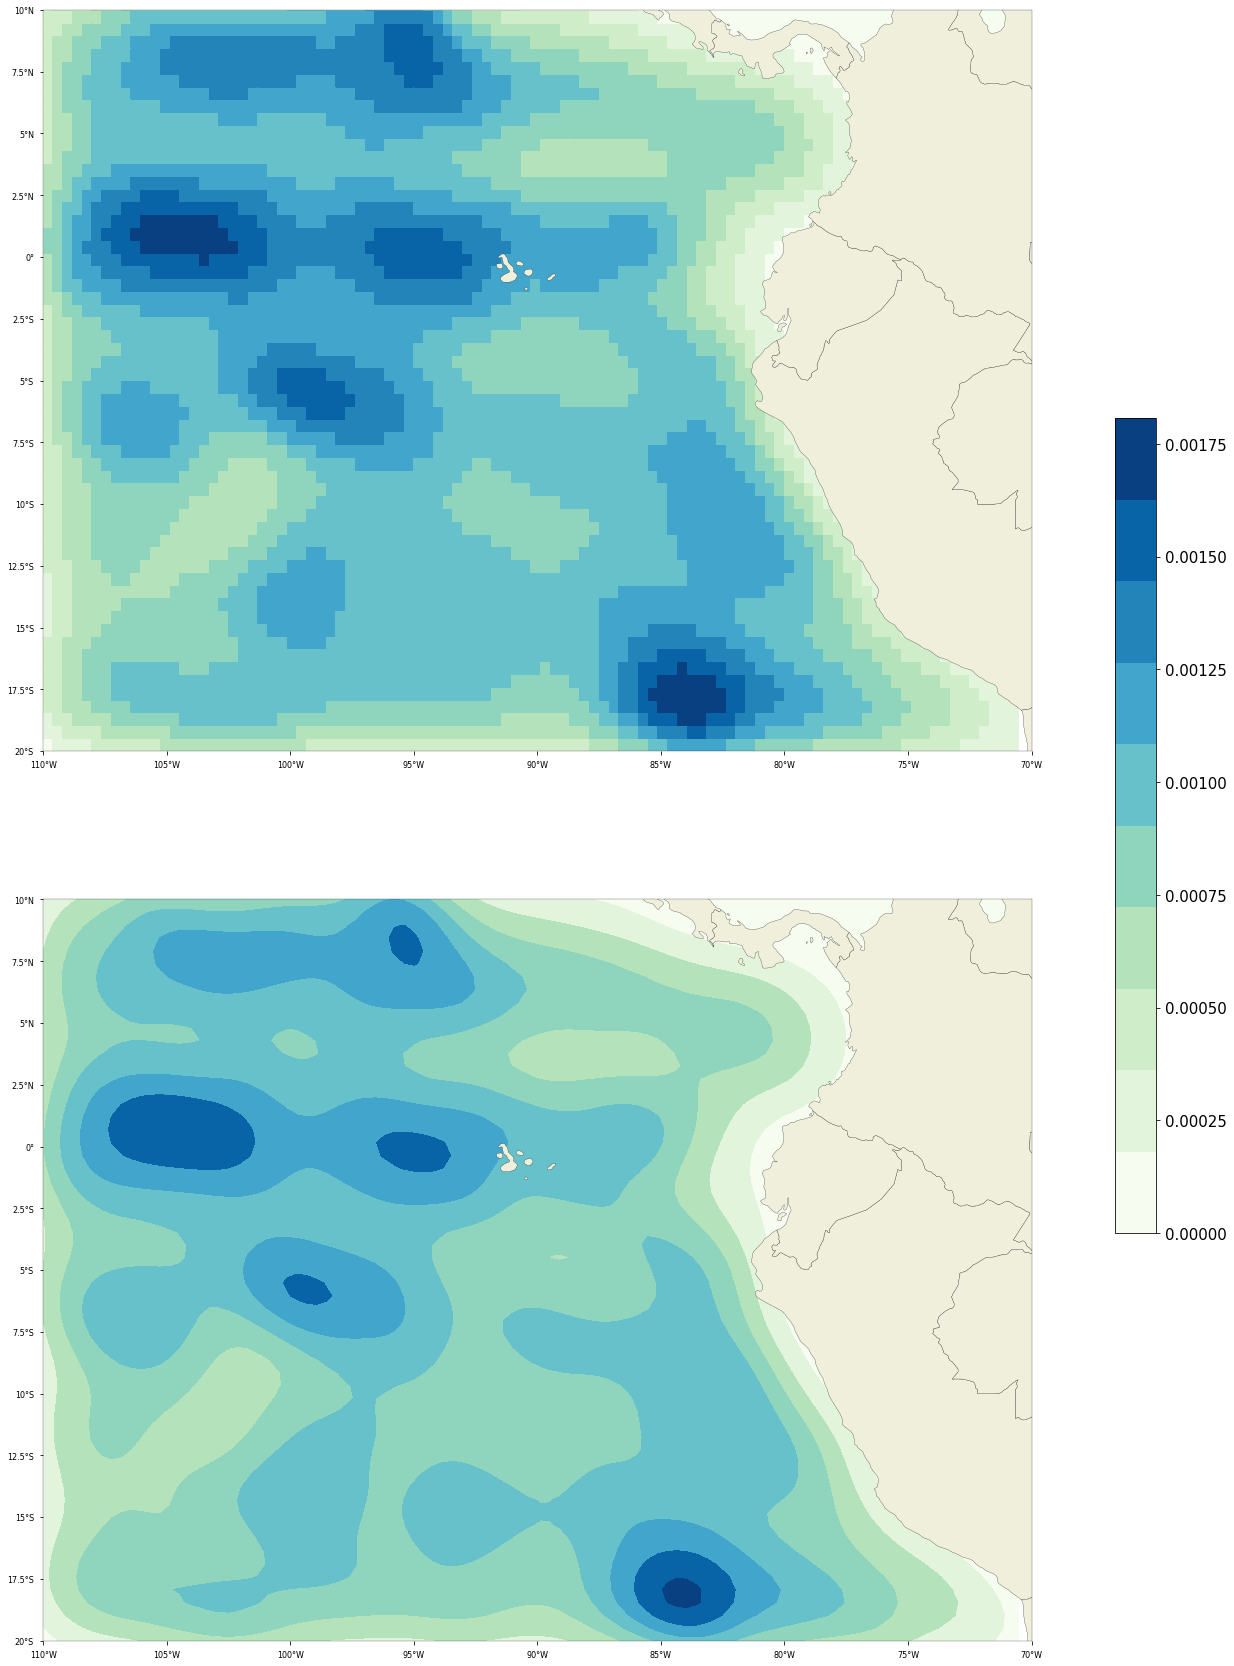

In [14]:
fig ,ax = plt.subplots(2,1,subplot_kw=dict(projection=proj),figsize=(30,30))
ax1 = ax[0] #= fig.add_subplot(211)
ax1.set_xticks(np.arange(0,360,5), crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(-90,90,2.5), crs=ccrs.PlateCarree())
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.add_feature(hq_border)
ax1.set_extent([70, 110, -20, 10], crs=proj)

ax2 = ax[1] #fig.add_subplot(212)
ax2.set_xticks(np.arange(0,360,5), crs=ccrs.PlateCarree())
ax2.set_yticks(np.arange(-90,90,2.5), crs=ccrs.PlateCarree())
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.add_feature(hq_border)
ax2.set_extent([70, 110, -20, 10], crs=proj)

# alpha=0.5 will make the plots semitransparent
a = ax1.pcolormesh(xi, yi, zi.reshape(xi.shape),transform=ccrs.PlateCarree(),cmap=plt.get_cmap('GnBu',10))
ax2.contourf(xi, yi, zi.reshape(xi.shape),transform=ccrs.PlateCarree(),cmap=plt.get_cmap('GnBu',10))
cbar = fig.colorbar(a, orientation='vertical', ax=ax.flat, shrink=0.5)
cbar.ax.tick_params(labelsize=15)

fig.savefig('kde_argo.png', dpi=400)

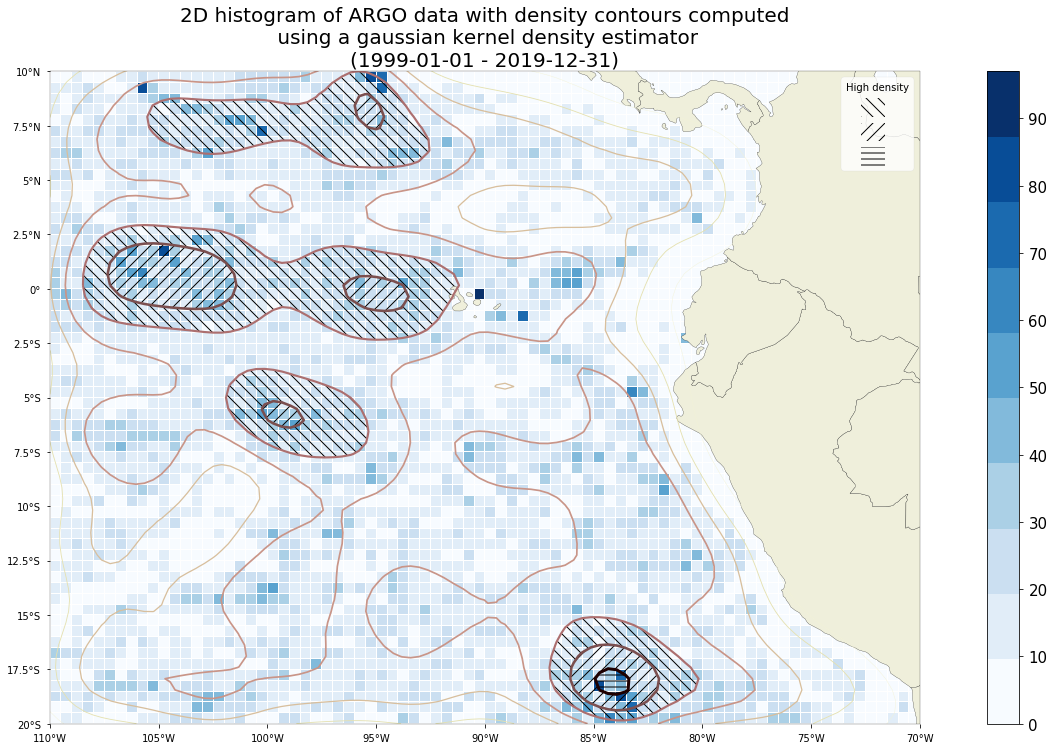

In [15]:
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
plt.style.use('seaborn-paper')

proj = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(subplot_kw=dict(projection=proj),figsize=(24,12))
ax.set_xticks(np.arange(0,360,5), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90,90,2.5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
X, Y = np.meshgrid(xedges, yedges)

hq_land = cfeature.NaturalEarthFeature(
                            category='physical',
                            name='land',
                            scale='50m',
                            facecolor=cfeature.COLORS['land'])
hq_border = cfeature.NaturalEarthFeature(
                            category='cultural',
                            name='admin_0_countries',
                            scale='50m',
                            facecolor=cfeature.COLORS['land'],
                            edgecolor='black')
#ax.add_feature(hq_land)
ax.add_feature(hq_border)
ax.set_extent([70, 110, -20, 10], crs=proj)
draw = ax.pcolormesh(X, Y, H,edgecolor='w',lw=0.004,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('Blues',10))
ax.contour(xi, yi, zi.reshape(xi.shape),levels=8,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('pink_r',8),linewidths=np.linspace(0,3,8))

cmap = plt.get_cmap('pink_r',8)
cmaplist = [cmap(i) for i in range(cmap.N)]
for j in range(len(cmaplist)):
    cmaplist[j] = (1.,1.,1.,0)
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

cs = ax.contourf(xi, yi, zi.reshape(xi.shape),transform=ccrs.PlateCarree(),cmap=cmap,hatches=[None,None,None,None,None,'\\\\', '//','--'])
artists, labels = cs.legend_elements()
ax.legend(artists[-3:],['','',''], handleheight=2, title='High density',fancybox=True,fontsize='large')

cbar = plt.colorbar(draw, ticks = np.arange(np.min(H),np.max(H),10))
cbar.ax.tick_params(labelsize=15) 

ax.tick_params(labelsize='medium')
ax.set_title('2D histogram of ARGO data with density contours computed\n using a gaussian kernel density estimator\n({} - {})'.format(date1,date2),size=20)
fig.savefig('hist+kde_argo.png', dpi=400)

In [16]:
reg1, reg1x, reg1y = filter_data(data,-2.5,253,2.5,260,date1,date2)

In [17]:
reg1 = reg1.sort_values('date')
reg1.head()

,date,lat,lon,nprof,temp
2451,2001-04-17,1.759,258.712,8,29.067
3441,2001-08-08,1.802,260.339,0,21.800
3565,2001-08-18,0.892,258.958,1,21.704
3667,2001-08-25,2.005,258.713,12,25.386
3707,2001-08-29,0.711,258.257,10,23.928


In [18]:
template = '{:%Y%m%d}_prof.nc'
def get_fn(date, temp):
    return os.path.join(ARGO_DIR,temp.format(date))
reg1['fname'] = reg1['date'].apply(get_fn,args={template})

In [19]:
reg1=reg1.reset_index(drop=True)
reg1.head()

,date,lat,lon,nprof,temp,fname
0,2001-04-17,1.759,258.712,8,29.067,/data/datos/ARGO/data/20010417_prof.nc
1,2001-08-08,1.802,260.339,0,21.800,/data/datos/ARGO/data/20010808_prof.nc
2,2001-08-18,0.892,258.958,1,21.704,/data/datos/ARGO/data/20010818_prof.nc
3,2001-08-25,2.005,258.713,12,25.386,/data/datos/ARGO/data/20010825_prof.nc
4,2001-08-29,0.711,258.257,10,23.928,/data/datos/ARGO/data/20010829_prof.nc


In [20]:
reg1.iloc[-65:-50]

,date,lat,lon,nprof,temp,fname
3774,2018-10-28,1.39500,256.00000,137,23.191,/data/datos/ARGO/data/20181028_prof.nc
3775,2018-10-29,-0.73300,253.94600,43,24.069,/data/datos/ARGO/data/20181029_prof.nc
3776,2018-10-30,0.93149,255.30999,28,23.770,/data/datos/ARGO/data/20181030_prof.nc
3777,2018-10-30,2.44600,259.65200,60,26.435,/data/datos/ARGO/data/20181030_prof.nc
3778,2018-11-05,-0.75100,259.17100,166,23.750,/data/datos/ARGO/data/20181105_prof.nc
3779,2018-11-06,1.69800,253.77500,158,25.790,/data/datos/ARGO/data/20181106_prof.nc
3780,2018-11-06,0.30959,259.24035,217,25.107,/data/datos/ARGO/data/20181106_prof.nc
3781,2018-11-07,1.34100,255.89200,141,26.291,/data/datos/ARGO/data/20181107_prof.nc
3782,2018-11-08,-0.36300,253.17600,47,24.246,/data/datos/ARGO/data/20181108_prof.nc
3783,2018-11-09,1.94900,259.91300,59,26.510,/data/datos/ARGO/data/20181109_prof.nc


In [21]:
grid = np.arange(0,2001,10)
def get_temp(fname,prof):
    data = xr.open_dataset(fname)
    temp = data.TEMP[prof].data
#     salt = data.PSAL[prof].data
#     salt = gsw.conversions.SA_from_SP(salt)
    depth = gsw.conversions.z_from_p(data.PRES[prof],data.LATITUDE[prof])
    mask = ~np.isnan(temp)
    mask[np.where(depth == 0)] = False
    if temp[mask].size ==1:
        return np.full_like(grid, np.nan, dtype=np.double)
    try:
        func = PchipInterpolator(-depth[mask],temp[mask])#,kind='linear',fill_value=np.nan,bounds_error=False)
    except:
        print('Error on file {}'.format(fname))
        return np.full_like(grid, np.nan, dtype=np.double)
    new_grid = np.where(grid>-depth[mask][-1],np.nan,grid)
    new_grid[np.where(grid<-depth[mask][0])] = np.nan
    new_data = func(new_grid)
    return new_data

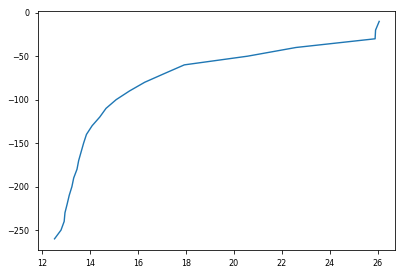

In [22]:
def reject_outliers(data, m = 4.6): 
    d = np.abs(data - np.median(data)) 
    mdev = np.median(d) 
    s = d/mdev if mdev else 0. 
    return data[s<m], s<m

a=2664
plt.plot(get_temp(reg1.loc[a]['fname'], reg1.loc[a]['nprof']), -grid)

In [419]:
new_df = pd.DataFrame([],index=reg1['date'],columns=grid)
for ind in reg1.index:
    new_df.iloc[ind] = get_temp(reg1.iloc[ind]['fname'],reg1.iloc[ind]['nprof'])
new_df.head()

,0,10,20,30,40,50,60,70,80,90,...,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000
date,,,,,,,,,,,,,,,,,,,,,
2001-04-17,NaN,27.127,25.422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-08-08,NaN,21.89,21.8888,21.7455,21.6381,21.5433,21.4124,21.1678,18.5567,17.0159,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-08-18,NaN,21.7451,21.6147,20.9932,19.9507,18.4866,17.9592,16.9883,15.8134,14.5985,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-08-25,NaN,25.536,25.5333,25.5175,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-08-29,NaN,24.0809,24.0172,22.1733,19.2943,18.0446,16.7677,14.8995,14.1919,14.0207,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [426]:
new_df.to_csv('temp_prof_ts.txt')

In [65]:
new_df = pd.read_csv('temp_prof_ts.txt',index_col='date',parse_dates=True,dtype=np.float64)
new_df.iloc[:10]

,0,10,20,30,40,50,60,70,80,90,...,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000
date,,,,,,,,,,,,,,,,,,,,,
2001-04-17,NaN,27.127022,25.421976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-08-08,NaN,21.890046,21.888753,21.745540,21.638072,21.543291,21.412397,21.167777,18.556698,17.015917,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-08-18,NaN,21.745122,21.614705,20.993216,19.950678,18.486599,17.959175,16.988273,15.813401,14.598521,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-08-25,NaN,25.535999,25.533338,25.517535,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-08-29,NaN,24.080875,24.017159,22.173261,19.294334,18.044574,16.767669,14.899452,14.191911,14.020717,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-09-07,NaN,20.442732,20.026641,19.031087,17.744247,17.436710,15.500189,14.784189,14.473221,14.120772,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-09-18,NaN,24.546967,24.529671,21.027959,19.515666,17.876996,14.823358,13.900922,13.852586,13.735617,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-09-28,NaN,24.504905,24.520983,24.455431,22.791860,21.174907,19.558038,18.692833,18.289651,17.413654,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-10-08,NaN,23.962473,23.993112,23.952204,23.763781,23.189997,22.537709,20.319704,17.055630,16.566759,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
new_df[new_df > 35] = np.nan

In [69]:
new_df = new_df.groupby('date').mean()

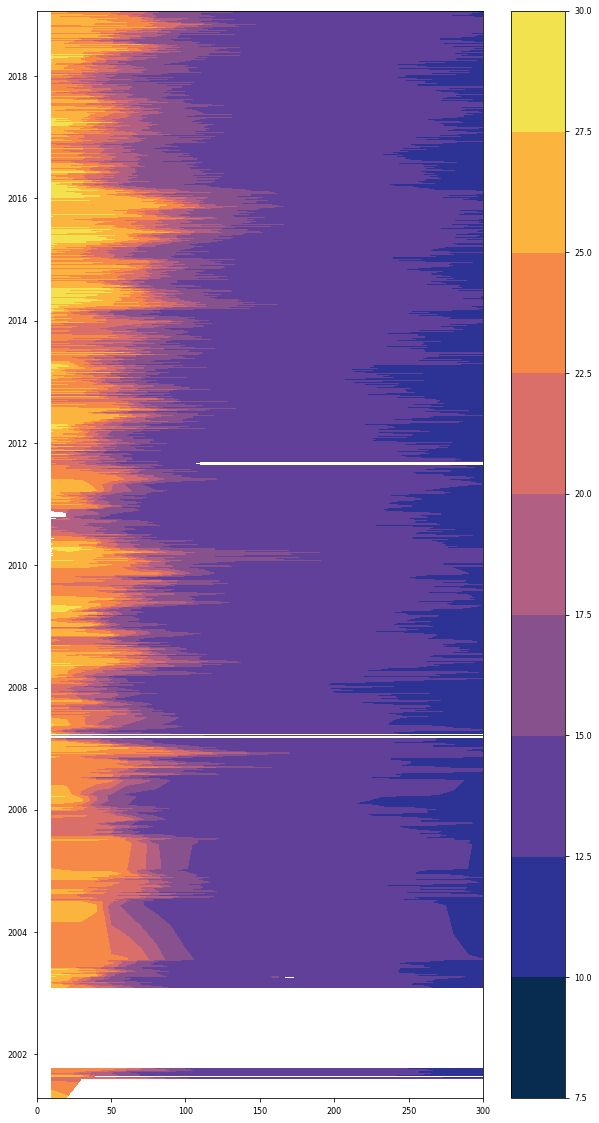

In [117]:
depth = 31
import cmocean as cmo
fig, ax = plt.subplots(figsize=(10,20))
# dra = ax.pcolormesh(new_df.columns.astype(np.int), new_df.index, new_df.values, cmap=cmo.cm.thermal)
dra = ax.contourf(new_df.columns.astype(np.int)[:depth], new_df.index, new_df.values[:,:depth],cmap=cmo.cm.thermal)
plt.colorbar(dra)

In [53]:
np.nanmax(new_df.values)

29.781822675308156

In [108]:
new_df.columns.shape

(201,)

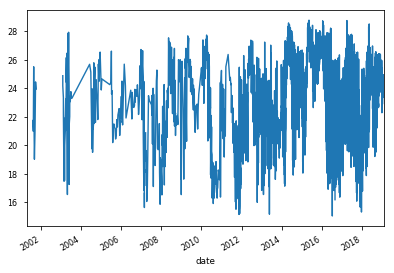

In [428]:
new_df[30].plot()